### Validates the BR08 discrete variance decay algorithm for numerical mixing.
Analyze output of MPAS-O setup as a doubly-periodic channel. Initial zonal velocity only, all other debug flags configured such that the model behaves as a linear advection equation

In [1]:
#Packages 
import numpy as np
import xarray as xr
import glob
import cmocean.cm as cmo
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import warnings
warnings.filterwarnings("ignore") #turns off annoying warnings
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FuncFormatter
import mosaic
from matplotlib.colors import SymLogNorm
from matplotlib.colors import LinearSegmentedColormap

In [2]:
def center_vertices(dsg, hres):
    # Clean up the indexing so the domain is centered for plotting

    # Original vertices (x,y) arrays
    xv = dsg.xVertex.values
    yv = dsg.yVertex.values
    
    # Compute the new vertices based on your filtering and offset logic:
    
    # 1. Extract verticesOnCell (assuming shape: [nCells, maxVerticesPerCell])
    voc = dsg.verticesOnCell.values
    
    # 2. Build verts as in your snippet (shape: [nCells, maxVerticesPerCell, 2])
    verts = np.dstack((xv[voc - 1], yv[voc - 1]))
    nverts = np.sum(voc != 0, axis=1)
    verts_list = [vert[:n] for vert, n in zip(verts, nverts)]
    
    # 3. Filter verts using np.ptp
    idx = [np.ptp(vert[:, 0]) < 50000 for vert in verts_list]
    verts_filtered = np.array(verts_list)[idx]
    
    # 4. Copy and apply offsets
    nuverts = verts_filtered.copy()
    m_dsx = hres
    nuverts[:, :, 0] += m_dsx / 2
    nuverts[:, :, 1] -= m_dsx
    
    # Now, update dsg's xVertex and yVertex arrays accordingly:
    # But note: verts are grouped by cell, so we need to flatten and assign properly.
    
    # Because verts_filtered is a filtered subset of verts_list,
    # you should update only those cells where idx is True.
    
    # Get indices of cells that passed filter
    filtered_cells = np.where(idx)[0]
    
    # Create copies of xVertex and yVertex to modify
    new_xVertex = xv.copy()
    new_yVertex = yv.copy()
    
    # Loop over filtered cells and update the corresponding vertex coords
    for cell_i, verts_cell in zip(filtered_cells, nuverts):
        nv = verts_cell.shape[0]  # number of vertices for this cell
        vertex_inds = voc[cell_i, :nv] - 1  # zero-based vertex indices for this cell
        new_xVertex[vertex_inds] = verts_cell[:, 0]
        new_yVertex[vertex_inds] = verts_cell[:, 1]
    
    # Assign back to dsg (if dsg is an xarray Dataset or DataArray)
    dsg['xVertex'].values = new_xVertex
    dsg['yVertex'].values = new_yVertex

In [3]:
# Choose one root directory, useful for multiple resolutions
rootdir = '/pscratch/sd/d/dylan617/mnum_val/br08_validation/'

# Load datasets
dsi = xr.open_dataset(rootdir + 'channel_init.nc')
dso = xr.open_dataset(rootdir + 'output.nc', chunks={'Time': 1})#.isel(Time=slice(1, None))
dsd = xr.open_dataset(rootdir + 'analysis_members/discreteVarianceDecay.0001-01-01.nc')
# interp_mphy(dsd) # Call interpolation of physical mixing
center_vertices(dsi, 1.0) # Call fixing of vertices, second arg is horz res in meters

# dso.xtime

In [7]:
dsi.bottomDepth

<xarray.DataArray 'bottomDepth' (nCells: 11600)> Size: 93kB
[11600 values with dtype=float64]
Dimensions without coordinates: nCells

### Check that the initial velocity is equal to 1 in the zonal direction and zero in the meridional

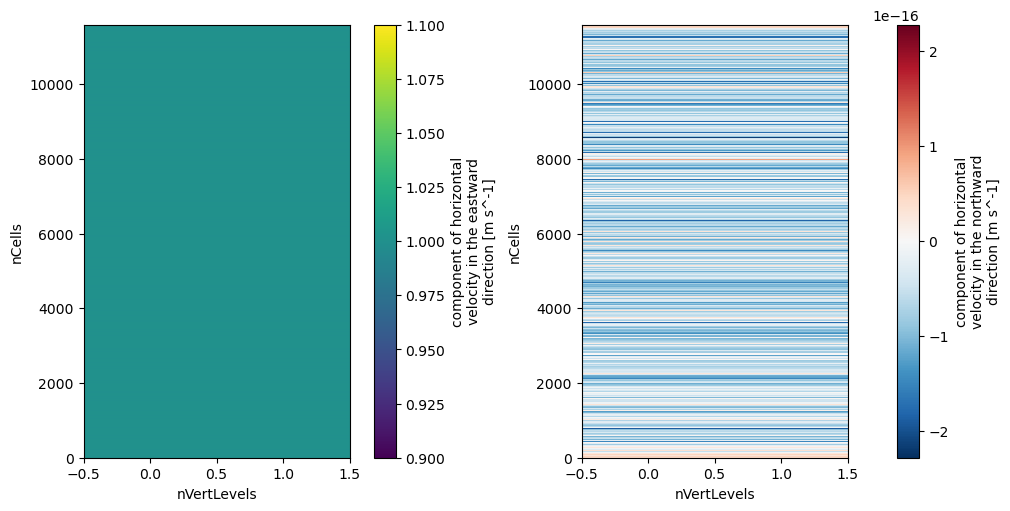

In [4]:
fig, ax = plt.subplots(1,2, constrained_layout=True, figsize=(10,5))
dso.velocityZonal[0].plot(ax=ax[0])
dso.velocityMeridional[0].plot(ax=ax[1])

### Now check the last timestep 

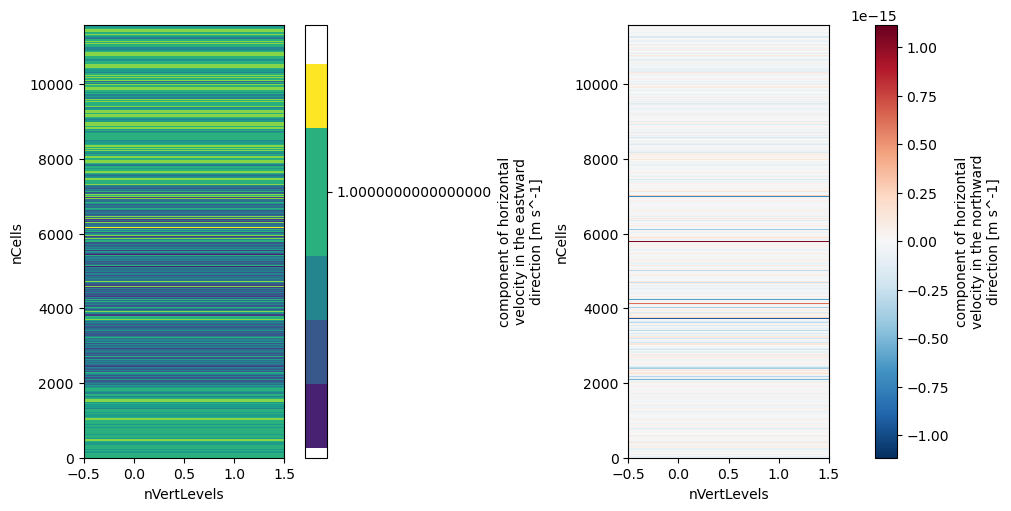

In [5]:
fig, ax = plt.subplots(1,2, constrained_layout=True, figsize=(10,5))
dso.velocityZonal[-1].plot(ax=ax[0])
dso.velocityMeridional[-1].plot(ax=ax[1])

In [6]:
# Mosaic descriptor object, needed to plot the polygons
descriptor = mosaic.Descriptor(dsi,use_latlon=False)

# Used for plotting mnum on a diverging log colorbar
# Otherwise the extrema look the same for most cmocean maps. That is, 
# you can't tell dark reds or blues apart. 
def truncate_colormap(cmap, minval=0.0, maxval=0.8, n=256):
    """Truncates a colormap to use only part of the range."""
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

curl = truncate_colormap(plt.get_cmap('cmo.curl'), 0.1, 0.9)

# Helper to safely compute log10 for plotting, otherwise it is masked for 
# very small values
def safe_log10(data, floor=1e-10):
    """Compute log10 of xarray DataArray safely, keeping dimensions and attrs."""
    # Replace nonpositive or nonfinite values with floor
    data_clean = data.where((data > 0) & np.isfinite(data), other=floor)
    return np.log10(data_clean)

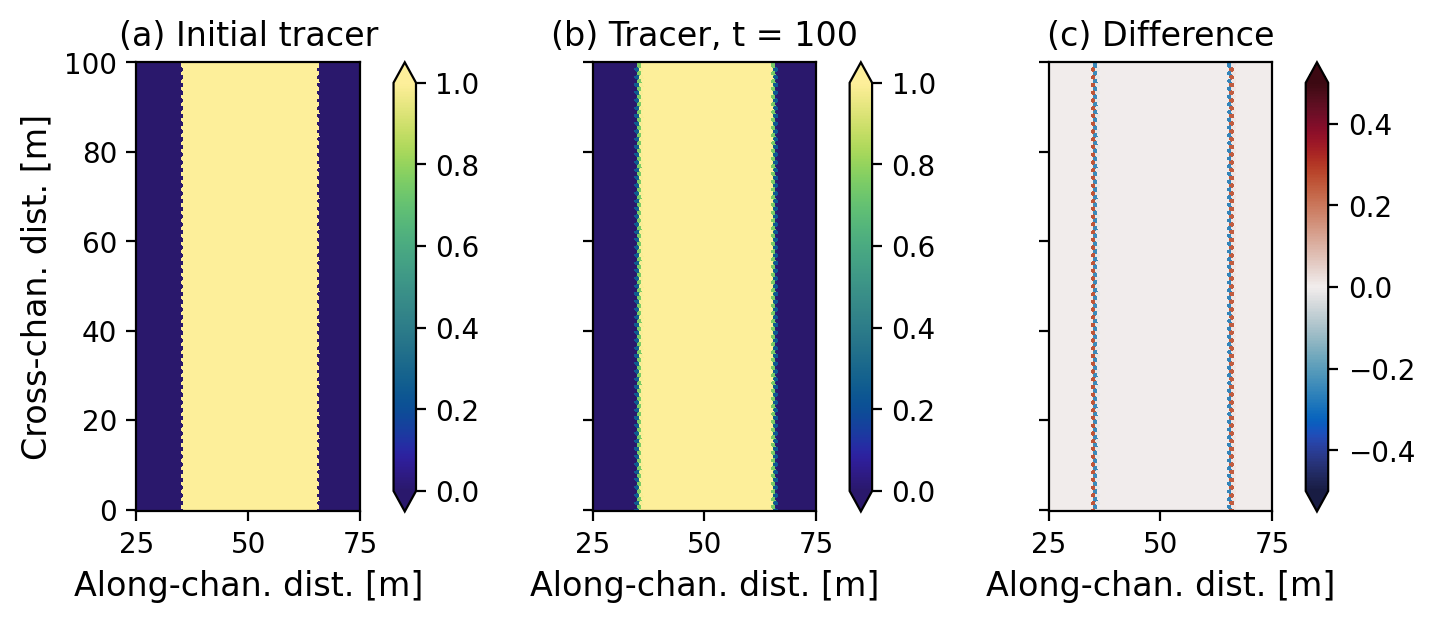

In [7]:
z = 0; t=-1
fig, axes = plt.subplots(1, 3, figsize=(7, 3), constrained_layout=True, dpi = 200)

# Panel (a): Salinity
c = mosaic.polypcolor(axes[0], descriptor,
                      dsi.salinity.isel(nVertLevels=z, Time=0),
                      cmap=cmo.haline, vmin=0, vmax=1,
                      antialiaseds=False)
fig.colorbar(c, ax=axes[0], extend='both')

# Panel (a): Salinity
c = mosaic.polypcolor(axes[1], descriptor,
                      dso.temperature.isel(nVertLevels=z, Time=t),
                      cmap=cmo.haline, vmin=0, vmax=1,
                      antialiaseds=False)
fig.colorbar(c, ax=axes[1], extend='both')

# # Panel (a): Salinity
c = mosaic.polypcolor(axes[2], descriptor,
                      dso.temperature.isel(nVertLevels=z, Time=t)-dso.salinity.isel(nVertLevels=z, Time=0),
                      cmap=cmo.balance, vmin=-.5, vmax=.5,
                      antialiaseds=False)

fig.colorbar(c, ax=axes[2], extend='both')


for ax in axes:
    # ax.set_xticks(np.arange(0, 350000, 50000))
    # ax.set_yticks(np.arange(0, 350000, 50000))
    ax.set_xlim(25,75)
    # ax.set_ylim(0, 101)
    ax.set_aspect(1.0)
    # ax.set_xticklabels([str(x) for x in ax.get_xticks()])
    # ax.set_yticklabels([str(y) for y in ax.get_yticks()])
    ax.set_xlabel('Along-chan. dist. [m]', fontsize=12)
    ax.set_ylabel('Cross-chan. dist. [m]', fontsize=12)

for ax in axes[1:]:
    ax.set_ylabel('')
    ax.set_yticklabels('')

axes[0].set_title('(a) Initial tracer')
axes[1].set_title('(b) Tracer, t = 100')
axes[2].set_title(r'(c) Difference')
plt.savefig('plan_view_channel.png',dpi=200, bbox_inches='tight')

### Analytical profile 

In [8]:
# --- Initial top-hat tracer profile: from 35 m to 65 m ---
def s0(x):
    return np.where((x >= 35) & (x <= 65), 1.0, 0.0)

# --- Equation 9: Periodic advection of tracer ---
def s_xt(x, t, u, L):
    shifted_x = (x - u * t) % L
    return s0(shifted_x)

# --- Parameters ---
L = 100       # domain length in meters
u = 1         # advection speed in m/s
t2 = 100     # time in seconds (e.g., after 30 seconds)
x = np.arange(1, L, 1)  # spatial grid (high resolution)

# --- Evaluate ---
s_t0 = s0(x)
s_t1 = s_xt(x, t2, u, L)

### Example zonal slice.
Not sure if I did this right, going to do a meridional average instead 

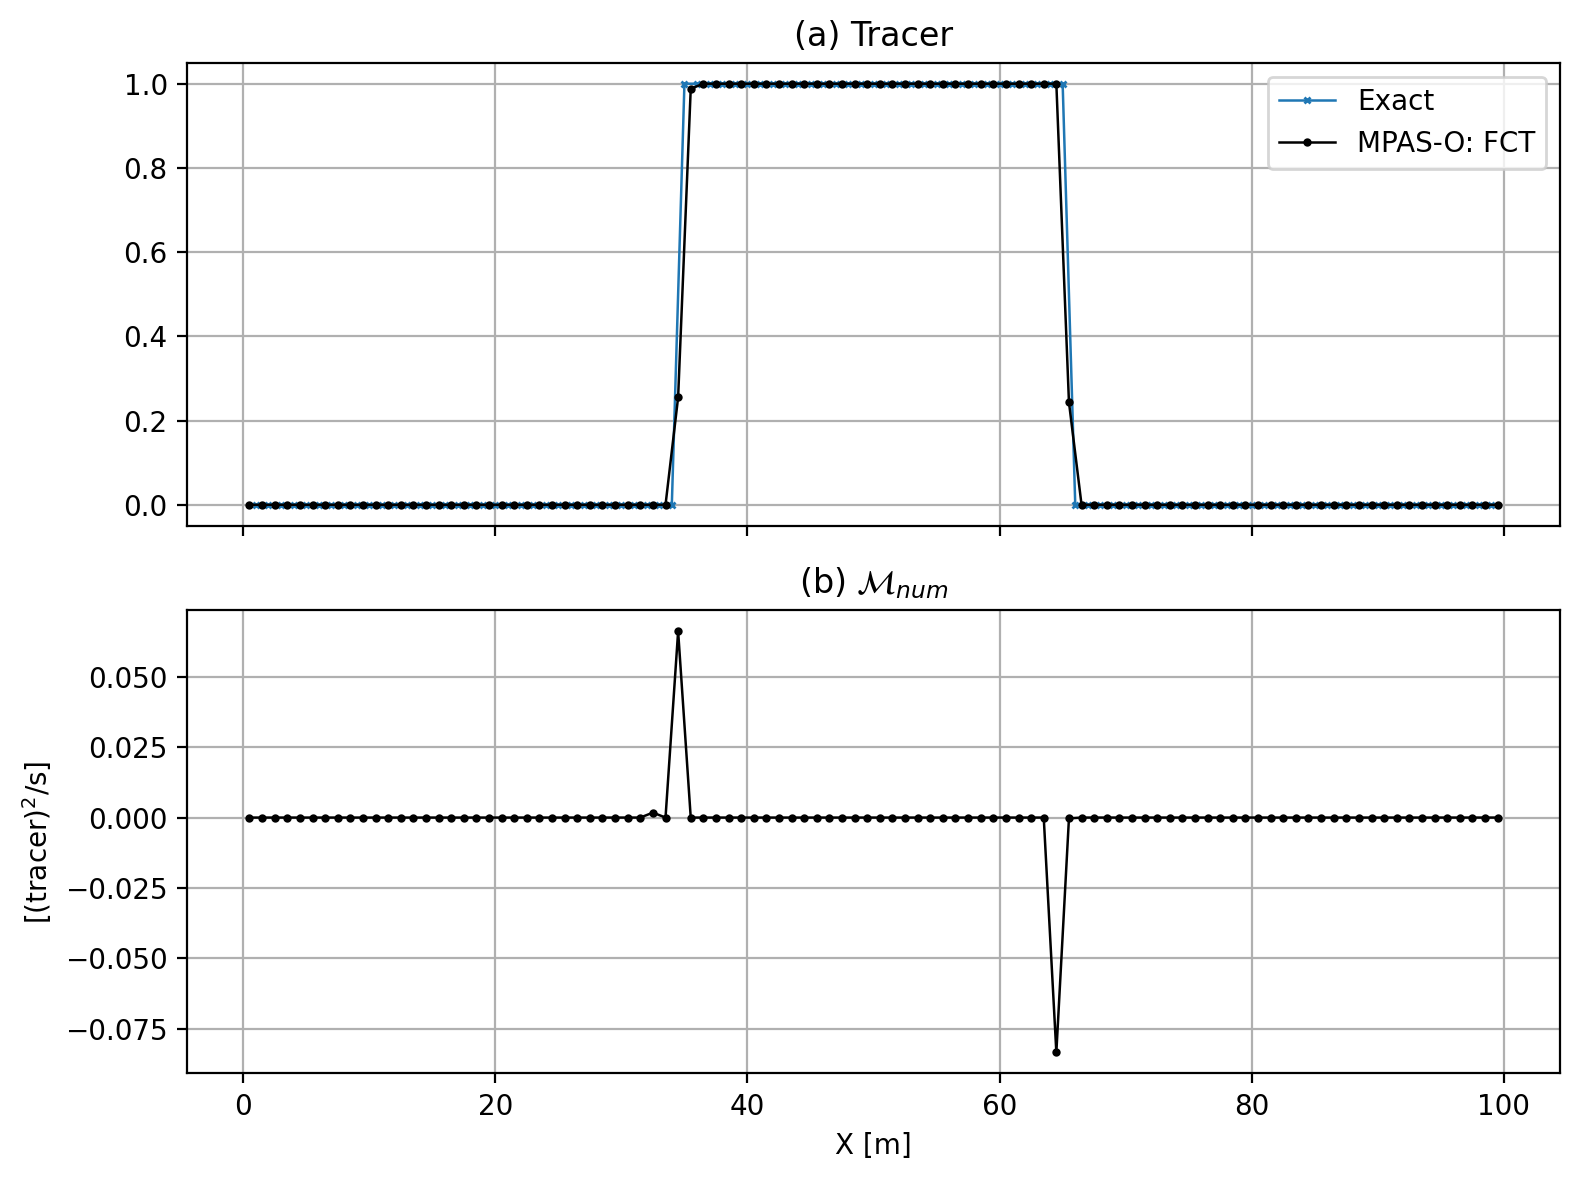

In [9]:
# --- Raw slice extraction at y ≈ 53 m ---
y_target = 53  # meters
dy_tol = 0.43     # tolerance
mask = (dsi.yCell >= y_target - dy_tol) & (dsi.yCell <= y_target + dy_tol)

# Coordinates and raw data
t = -1
x_raw = dsi.xCell.values[mask]
temp_raw = dso.temperature.isel(Time=t)[:,0].values[mask]
dvd_raw = dsd.chiSpurTempBR08.isel(Time=t)[:,0].values[mask]

# Sort by x
sort_idx = np.argsort(x_raw)
x_raw_sorted = x_raw[sort_idx]
temp_raw_sorted = temp_raw[sort_idx]
dvd_raw_sorted = dvd_raw[sort_idx]

# --- Plotting ---
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True, constrained_layout=True, dpi=200)

# Top panel: tracer profiles
x = np.arange(1, L, 1)  # FOU resolution
axs[0].plot(x, s_t1, label='Exact', marker='x', markersize=2, lw=0.9)
axs[0].plot(x_raw_sorted, temp_raw_sorted, label='MPAS-O: FCT', marker='o',markersize=2,lw=0.9, color='black')
axs[0].set_ylabel('')
axs[0].set_title(f'(a) Tracer')
axs[0].legend()
axs[0].grid()

# Bottom panel: numerical mixing
axs[1].plot(x_raw_sorted, dvd_raw_sorted, marker='o',markersize=2,lw=0.9, color='black')
axs[1].set_xlabel('X [m]')
axs[1].set_ylabel(r'[(tracer)$^2$/s]')
axs[1].set_title(r'(b) $\mathcal{M}_{num}$')
axs[1].grid()

plt.tight_layout()
plt.show()


### Meridional average 

In [10]:
x = dsi.xCell.values
y = dsi.yCell.values 
salt = dso.salinity.isel(Time=-1, nVertLevels=0).values 
dvd = dsd.chiSpurSaltBR08.isel(Time=-1, nVertLevels=0).values  

# Round x to reduce float noise
x_rounded = np.round(x, 6)
unique_x = np.unique(x_rounded)

meridional_avg = np.zeros_like(unique_x)
meridional_avg_dvd = np.zeros_like(unique_x)
for i, x_val in enumerate(unique_x):
    # Mask all cells at this x location
    mask = np.isclose(x_rounded, x_val, atol=1e-6)
    
    # Compute average across y (for all those x == x_val)
    meridional_avg[i] = np.mean(salt[mask])
    meridional_avg_dvd[i] = np.mean(dvd[mask])

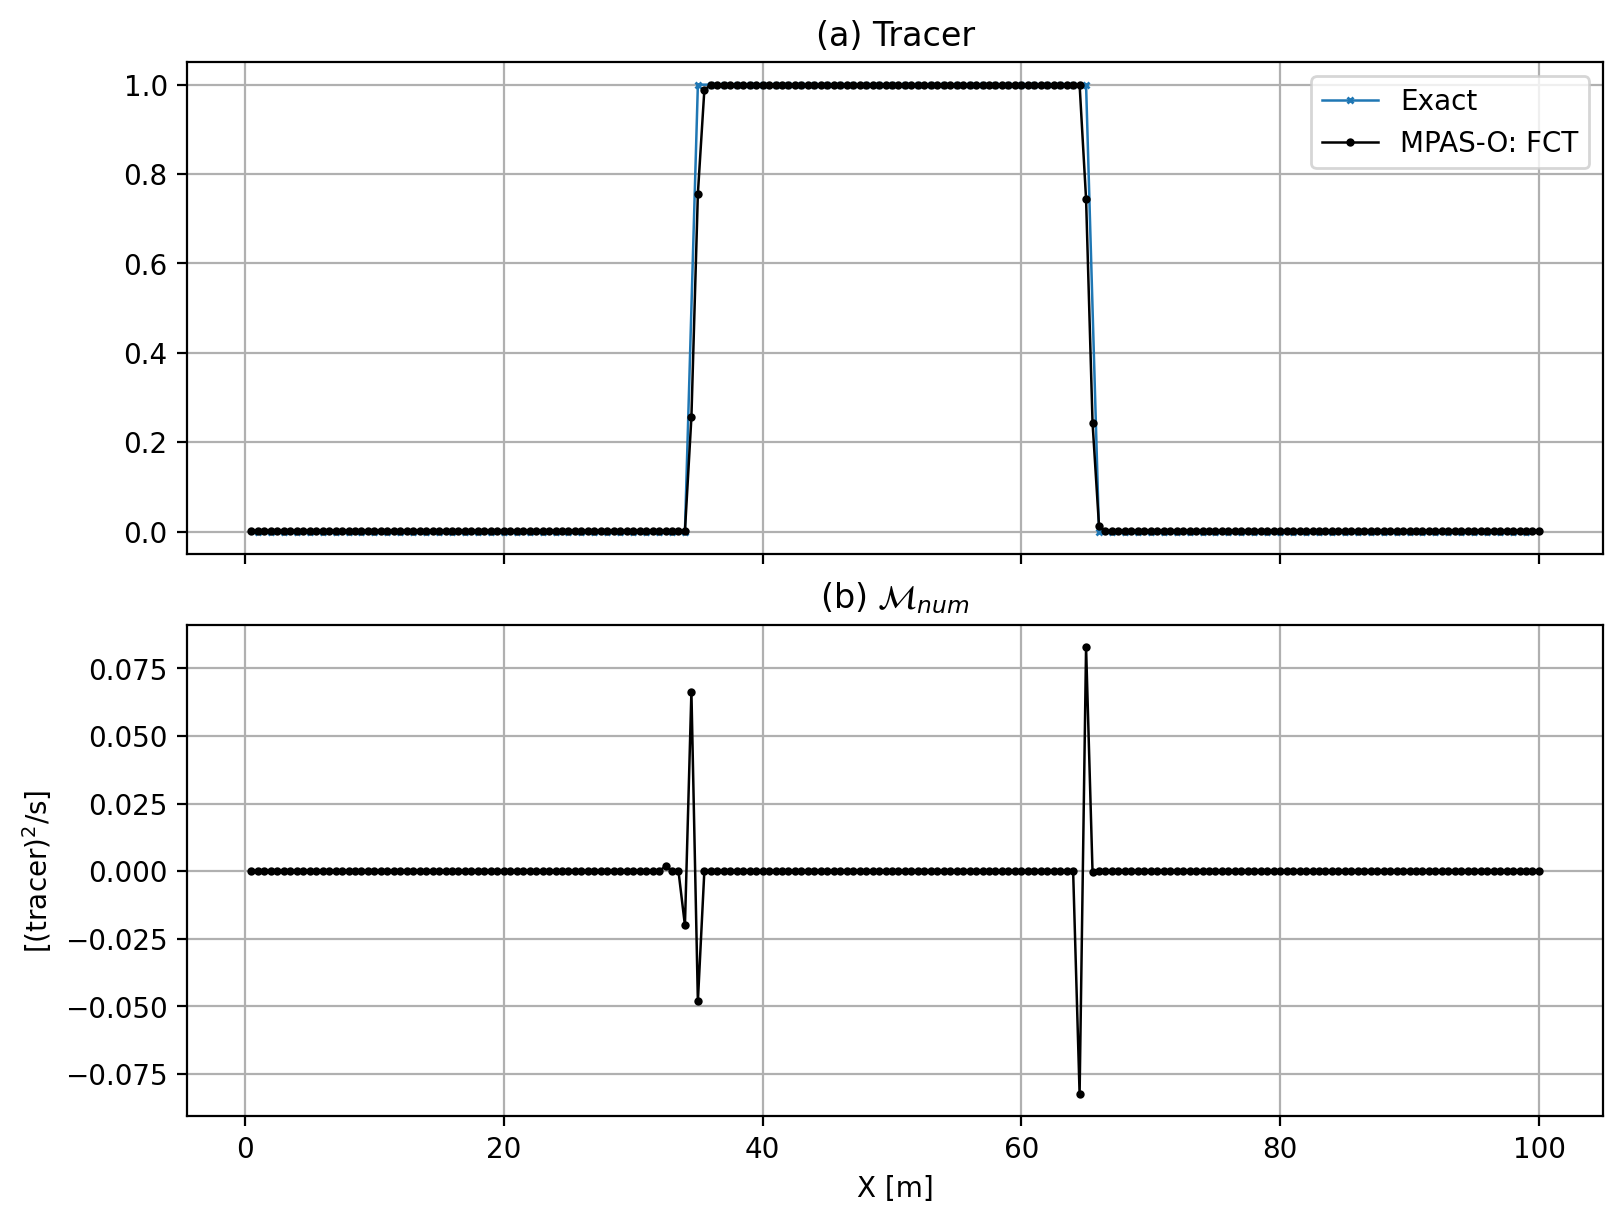

In [11]:
# --- Plotting ---
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True, constrained_layout=True, dpi=200)

# Top panel: tracer profiles
x = np.arange(1, L, 1) 
axs[0].plot(x, s_t1, label='Exact', marker='x', markersize=2, lw=0.9)
axs[0].plot(unique_x, meridional_avg, label='MPAS-O: FCT', marker='o',markersize=2,lw=0.9, color='black')
axs[0].set_ylabel('')
axs[0].set_title(f'(a) Tracer')
axs[0].legend()
axs[0].grid()

# Bottom panel: numerical mixing
axs[1].plot(unique_x, meridional_avg_dvd, marker='o',markersize=2,lw=0.9, color='black')
axs[1].set_xlabel('X [m]')
axs[1].set_ylabel(r'[(tracer)$^2$/s]')
axs[1].set_title(r'(b) $\mathcal{M}_{num}$')
axs[1].grid()

plt.savefig('meridional_avg.png',dpi=200, bbox_inches='tight')

### Compute volume-integrated salinity variance budget. 

In [12]:
dV = (dso.layerThickness*dsi.areaCell).astype('float64')
V = (dsi.areaCell*dso.layerThickness).sum(dim=['nVertLevels','nCells']).astype('float64')
sbar = (1/V)*((dso.salinity*dV).sum(dim=['nVertLevels','nCells'])).astype('float64')
svar = (dso.salinity-sbar)**2

dt = 1 #confirm in namelist
tend = ((svar.diff('Time')/dt)*dV.isel(Time=slice(1, None))).sum(dim=['nVertLevels','nCells'])

mnum_dv = (dsd.chiSpurSaltBR08*dsi.areaCell*dso.layerThickness).sum(dim=['nVertLevels','nCells']).astype(np.float64).isel(Time=slice(1, None))

### Plot salinity variance budget 

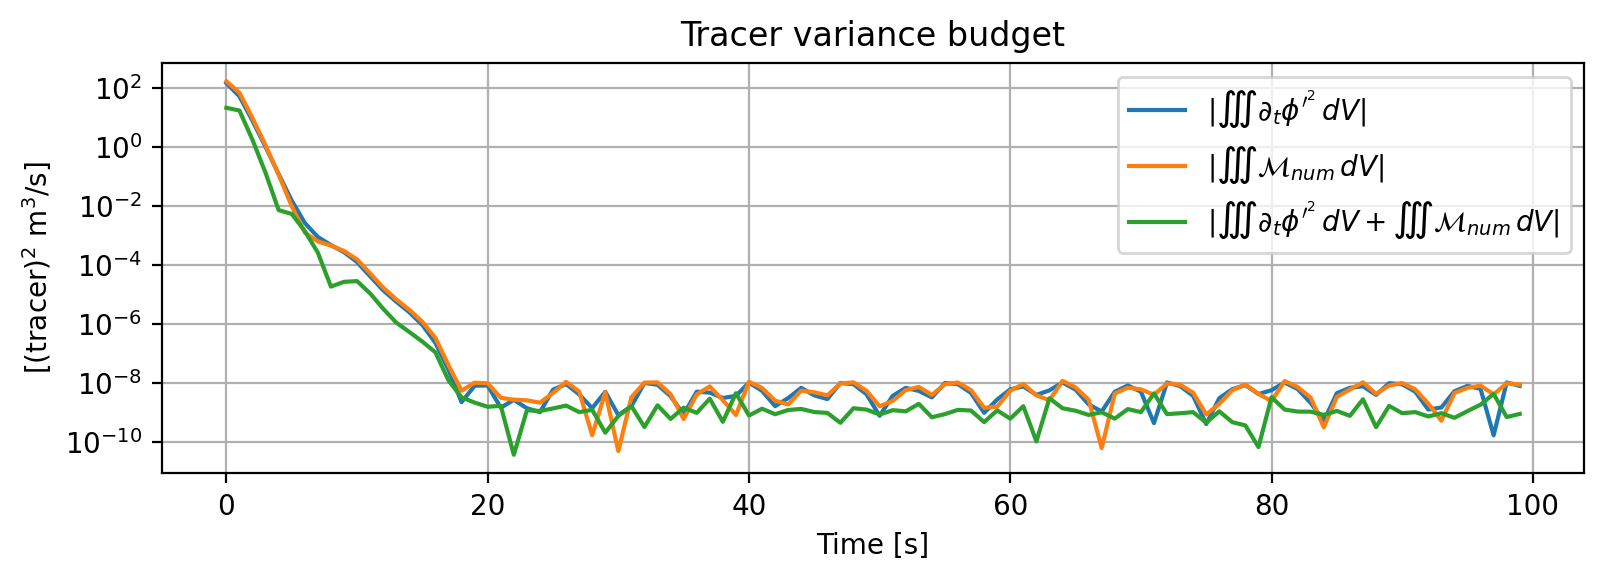

In [14]:
plt.figure(figsize=(8, 3),constrained_layout=True, dpi=200)
plt.plot(np.abs(tend), label=r'$|\iiint \partial_t \phi^{\prime^2} \, dV|$')
plt.plot(np.abs(-mnum_dv), label=r'$|\iiint \mathcal{M}_{num} \, dV|$')
plt.plot(np.abs(tend+mnum_dv), label = r'|$\iiint \partial_t \phi^{\prime^2} \, dV + \iiint \mathcal{M}_{num} \, dV$|')
plt.xlabel('Time [s]')
plt.ylabel('[(tracer)$^2$ m$^3$/s]')
plt.legend()
plt.title('Tracer variance budget')
plt.grid(True)
plt.tight_layout()
plt.semilogy()
plt.savefig('svar_budget.png',dpi=200, bbox_inches='tight')

### Calculate residual and compute error statistics 

In [35]:
residual = tend.values[1:] + mnum_dv.values[1:]  

# 1. Relative L2 error
rel_L2_error = np.linalg.norm(residual) / np.linalg.norm(tend)

# 2. Mean and max absolute residual
mean_resid = np.mean(np.abs(residual))
max_resid = np.max(np.abs(residual))

# 3. Correlation
from scipy.stats import pearsonr
corr, _ = pearsonr(-tend, mnum_dv)

print(f"Relative L2 error: {rel_L2_error:.15f}")
print(f"Mean residual: {mean_resid:.4e} psu²/s")
print(f"Max residual: {max_resid:.4e} psu²/s")
print(f"Correlation (r²): {corr**2:.4f}")

Relative L2 error: 0.110797789497998
Mean residual: 1.9274e-01 psu²/s
Max residual: 1.7200e+01 psu²/s
Correlation (r²): 0.9976


In [36]:
# adv = ((dso.velocityZonal[1:]*dso.dSdx_cell[1:])*(dsi.areaCell*dso.layerThickness[1:].astype(np.float64))).sum(dim=['nVertLevels','nCells']).astype(np.float64)
# adv